In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

print("Decision Tree Analysis - UFC Fight Prediction")
print("=" * 50)

df = pd.read_csv("../build/fight_ml_dataset.csv")


Decision Tree Analysis - UFC Fight Prediction


In [6]:
# 2. Feature Selection and Preprocessing
exclude_cols = [
    'DATE', 'EVENT', 'BOUT', 'fighter_a_name', 'fighter_b_name', 
    'winner_label', 'WEIGHTCLASS', 'METHOD', 'decision_type', 
    'method_class', 'decision_basis', 'TIME', 'TIME FORMAT', 
    'REFEREE', 'DETAILS', 'URL', 'fighter_a_url', 'fighter_b_url',
    'fighter_name_A', 'fighter_name_B', 'weight_class_A', 'weight_class_B',
    'stance_A', 'stance_B', 'date_of_birth_A', 'date_of_birth_B',
    'debut_date_A', 'debut_date_B', 'last_fight_date_A', 'last_fight_date_B'
]

df_clean = pd.read_csv("../build/fight_ml_dataset.csv")

# Get numeric features only
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in ['target'] + exclude_cols]

X = df_clean[feature_cols]
y = df_clean['target']

print(f"Features selected: {len(feature_cols)}")
print("Sample features:", feature_cols[:10])

# Handle missing values
missing_info = X.isnull().sum()
if missing_info.sum() > 0:
    print("\nMissing values found:")
    print(missing_info[missing_info > 0])
    X = X.fillna(X.median())
else:
    print("\nNo missing values found.")

Features selected: 41
Sample features: ['method_multiplier', 'ROUND', 'rounds_scheduled', 'current_elo_rating_A', 'total_fights_A', 'total_wins_A', 'total_losses_A', 'total_draws_A', 'win_rate_A', 'age_A']

No missing values found.


In [7]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")

Training set size: (6505, 41)
Test set size: (1627, 41)
Training target distribution: {1: 4196, 0: 2309}


In [8]:
# 4. Single Decision Tree Analysis
print("\n" + "="*50)
print("SINGLE DECISION TREE ANALYSIS")
print("="*50)

# Train a simple decision tree first
dt_simple = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_simple.fit(X_train, y_train)

# Predictions
y_pred_dt_simple = dt_simple.predict(X_test)
y_proba_dt_simple = dt_simple.predict_proba(X_test)[:, 1]

# Evaluate simple tree
print("Simple Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_simple):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_dt_simple):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_simple))


SINGLE DECISION TREE ANALYSIS
Simple Decision Tree Results:
Accuracy: 0.7763
ROC AUC: 0.8209

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       578
           1       0.84      0.81      0.82      1049

    accuracy                           0.78      1627
   macro avg       0.76      0.76      0.76      1627
weighted avg       0.78      0.78      0.78      1627



In [9]:
# 5. Hyperparameter Tuning for Decision Tree
print("\nTuning Decision Tree Hyperparameters...")

# Define parameter grid
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid search
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:")
print(dt_grid.best_params_)
print(f"Best CV Score: {dt_grid.best_score_:.4f}")

# Best decision tree
dt_best = dt_grid.best_estimator_
y_pred_dt_best = dt_best.predict(X_test)
y_proba_dt_best = dt_best.predict_proba(X_test)[:, 1]

print(f"\nBest Decision Tree Test Accuracy: {accuracy_score(y_test, y_pred_dt_best):.4f}")
print(f"Best Decision Tree Test ROC AUC: {roc_auc_score(y_test, y_proba_dt_best):.4f}")


Tuning Decision Tree Hyperparameters...
Best Decision Tree Parameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best CV Score: 0.8714

Best Decision Tree Test Accuracy: 0.7947
Best Decision Tree Test ROC AUC: 0.8732



DECISION TREE VISUALIZATIONS


/var/folders/bd/4xzyvv6x76g916r0mhtk5lbh0000gn/T/ipykernel_11876/3899027782.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')


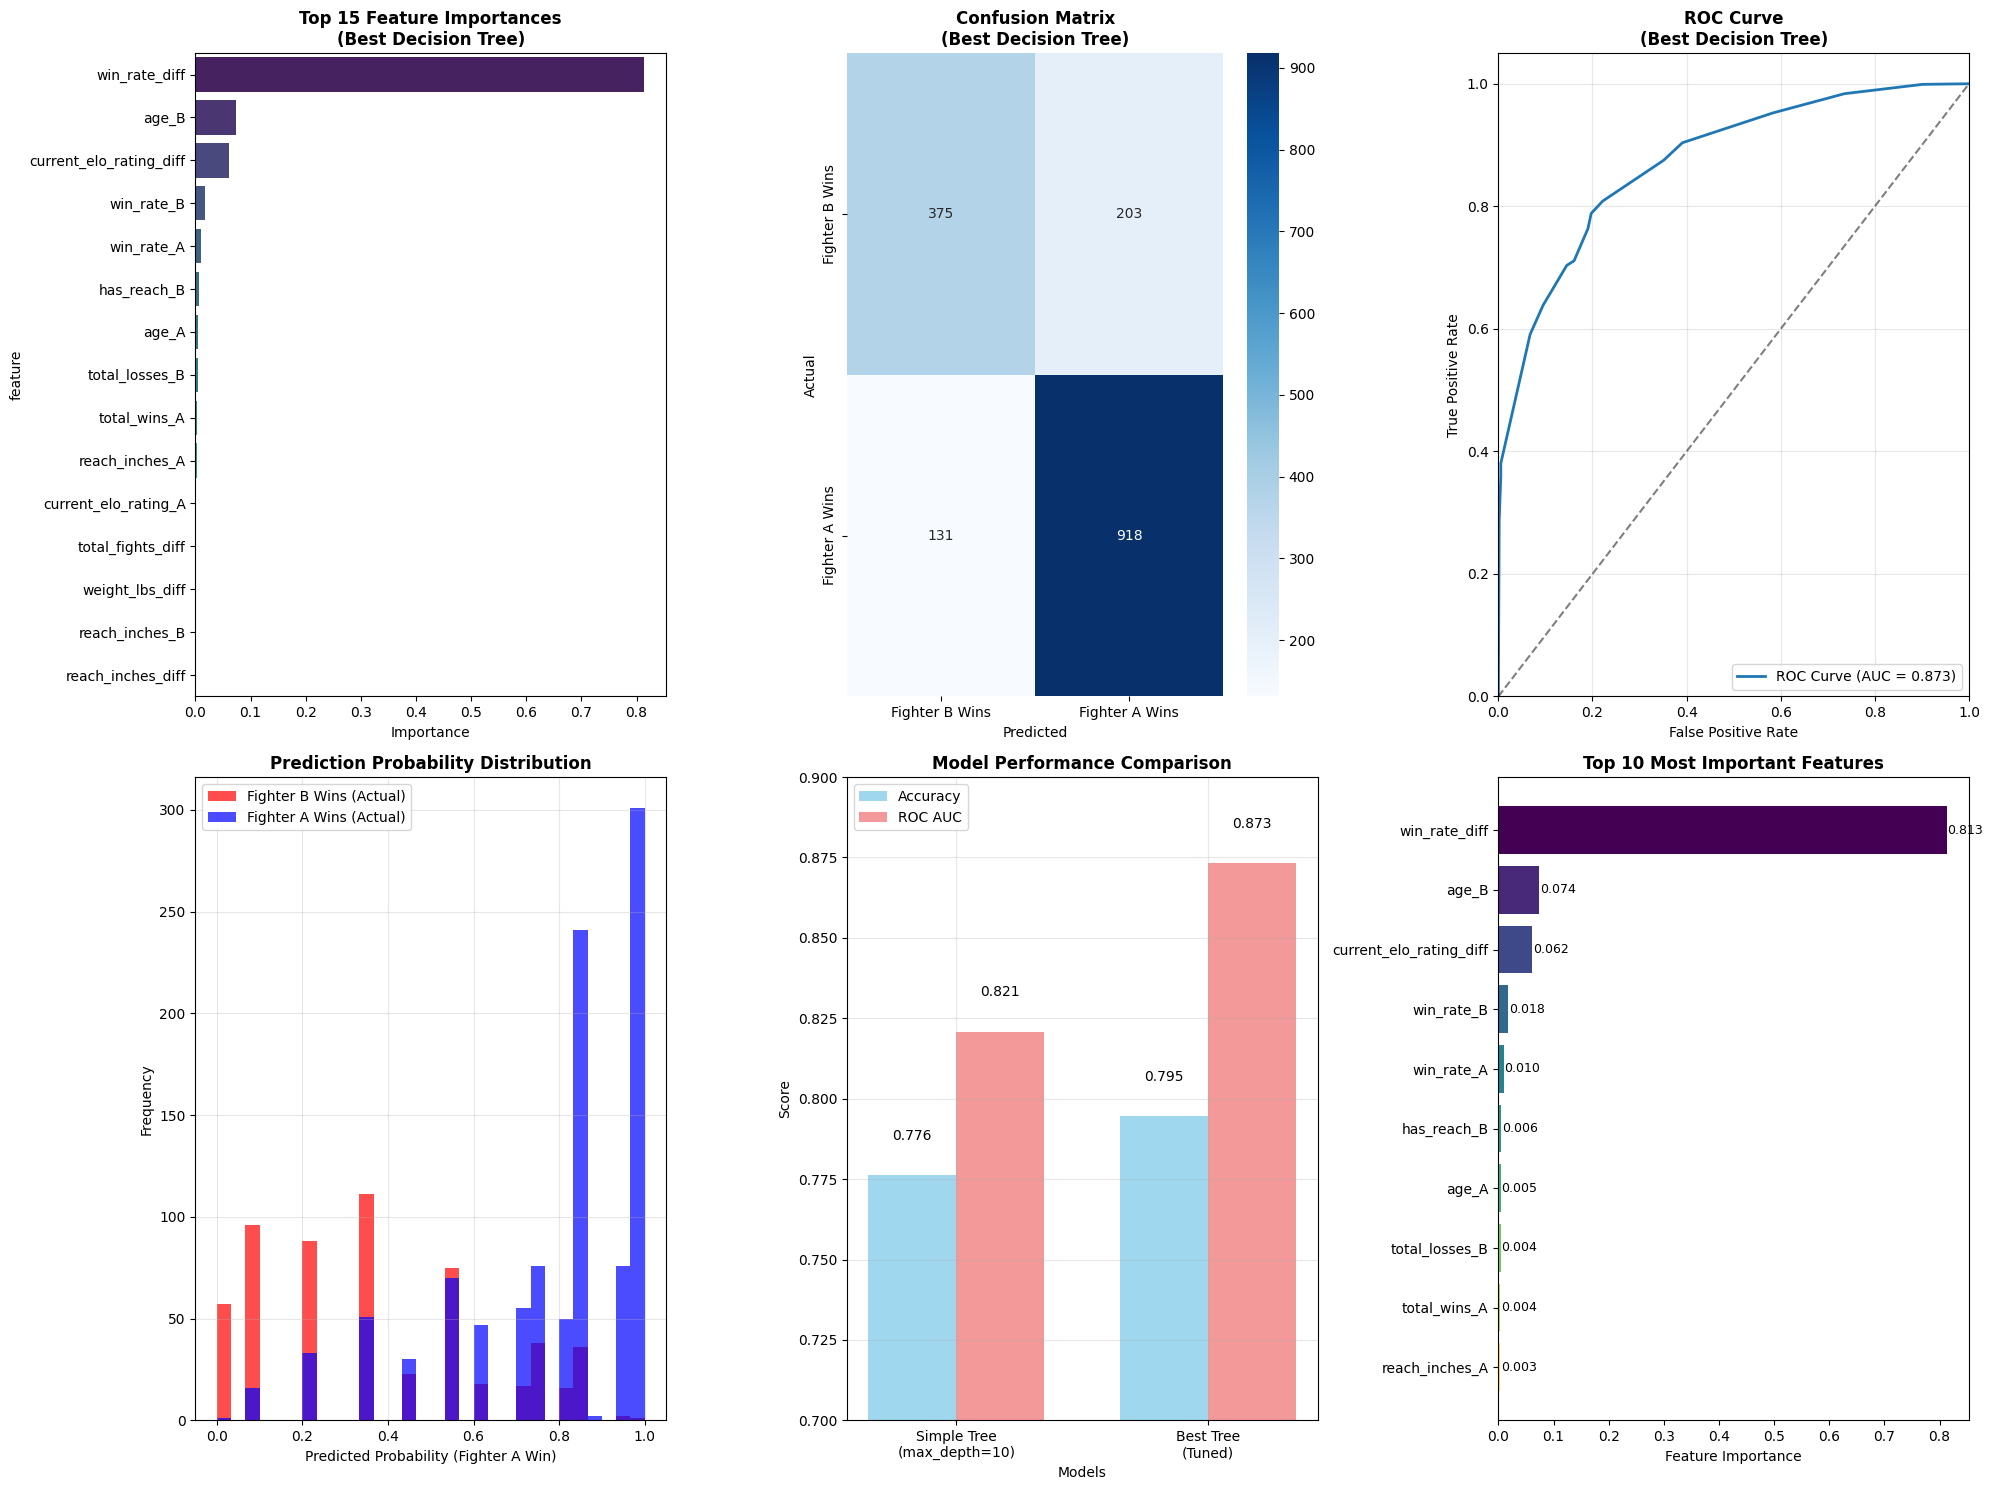

Top 5 Most Important Features:
win_rate_diff: 0.8127
age_B: 0.0744
current_elo_rating_diff: 0.0616
win_rate_B: 0.0182
win_rate_A: 0.0101


In [10]:
# 6. Decision Tree Visualizations
print("\n" + "="*50)
print("DECISION TREE VISUALIZATIONS")
print("="*50)

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# 1. Feature Importance Plot
plt.subplot(2, 3, 1)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False).head(15)

sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importances\n(Best Decision Tree)', fontsize=12, fontweight='bold')
plt.xlabel('Importance')
plt.tight_layout()

# 2. Confusion Matrix
plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, y_pred_dt_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fighter B Wins', 'Fighter A Wins'],
            yticklabels=['Fighter B Wins', 'Fighter A Wins'])
plt.title('Confusion Matrix\n(Best Decision Tree)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 3. ROC Curve
from sklearn.metrics import roc_curve
plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_proba_dt_best)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba_dt_best):.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n(Best Decision Tree)', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 4. Prediction Probability Distribution
plt.subplot(2, 3, 4)
plt.hist(y_proba_dt_best[y_test == 0], bins=30, alpha=0.7, label='Fighter B Wins (Actual)', color='red')
plt.hist(y_proba_dt_best[y_test == 1], bins=30, alpha=0.7, label='Fighter A Wins (Actual)', color='blue')
plt.xlabel('Predicted Probability (Fighter A Win)')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Model Comparison (Simple vs Best)
plt.subplot(2, 3, 5)
models = ['Simple Tree\n(max_depth=10)', 'Best Tree\n(Tuned)']
accuracies = [accuracy_score(y_test, y_pred_dt_simple), accuracy_score(y_test, y_pred_dt_best)]
aucs = [roc_auc_score(y_test, y_proba_dt_simple), roc_auc_score(y_test, y_proba_dt_best)]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
plt.bar(x + width/2, aucs, width, label='ROC AUC', alpha=0.8, color='lightcoral')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison', fontsize=12, fontweight='bold')
plt.xticks(x, models)
plt.legend()
plt.ylim(0.7, 0.9)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (acc, auc) in enumerate(zip(accuracies, aucs)):
    plt.text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, auc + 0.01, f'{auc:.3f}', ha='center', va='bottom')

# 6. Feature Importance Comparison (Top 10)
plt.subplot(2, 3, 6)
top_features = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    plt.text(importance + 0.001, i, f'{importance:.3f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Top 5 Most Important Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")



DECISION TREE STRUCTURE
Visualization Tree Performance:
Accuracy: 0.7830
ROC AUC: 0.8665


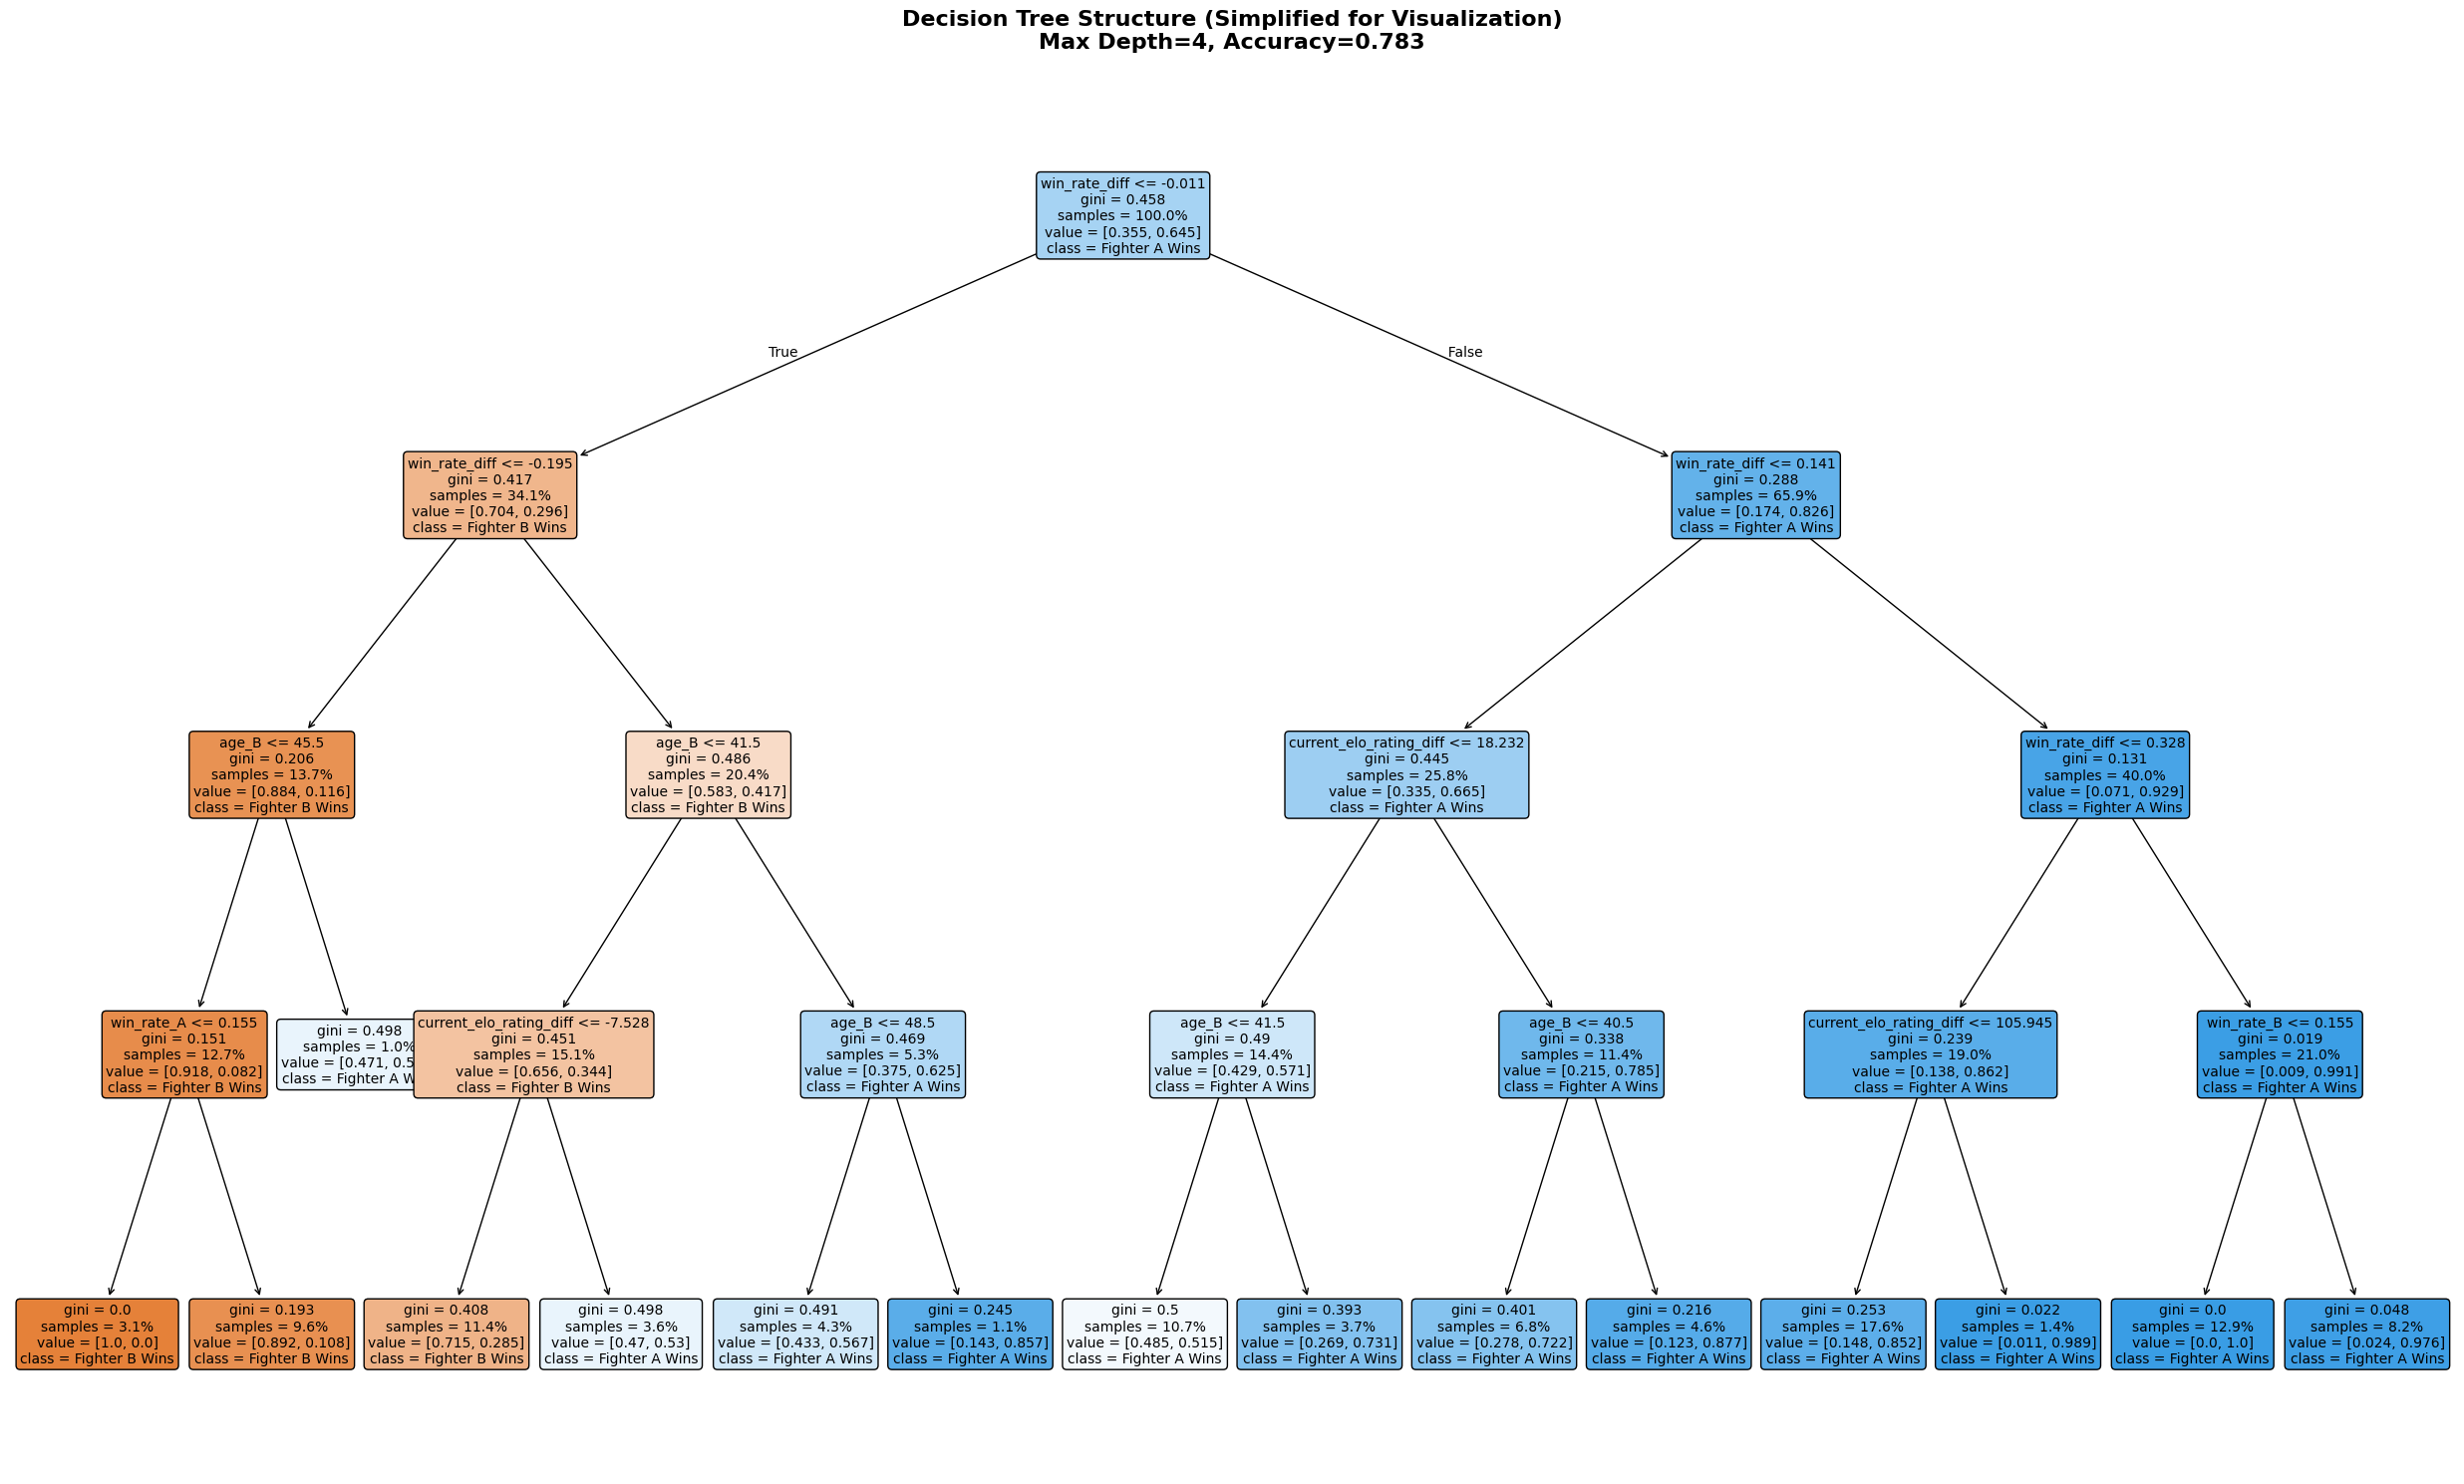


Tree Interpretation Guide:
- Each box shows: [decision rule] or [prediction]
- 'gini' = impurity measure (lower = more pure)
- 'samples' = proportion of training data in this node
- 'value' = [proportion of Fighter B wins, proportion of Fighter A wins]
- Color intensity = prediction confidence (darker = more confident)
- Orange = Fighter B wins, Blue = Fighter A wins


In [11]:
# 7. Decision Tree Structure Visualization
print("\n" + "="*50)
print("DECISION TREE STRUCTURE")
print("="*50)

# Create a smaller, more interpretable tree for visualization
dt_viz = DecisionTreeClassifier(
    max_depth=4,  # Limit depth for readability
    min_samples_split=100,  # Require more samples to split
    min_samples_leaf=50,    # Require more samples in leaf
    random_state=42
)
dt_viz.fit(X_train, y_train)

# Evaluate the visualization tree
y_pred_viz = dt_viz.predict(X_test)
y_proba_viz = dt_viz.predict_proba(X_test)[:, 1]

print(f"Visualization Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_viz):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_viz):.4f}")

# Plot the tree structure
plt.figure(figsize=(25, 15))
plot_tree(dt_viz, 
          feature_names=feature_cols,
          class_names=['Fighter B Wins', 'Fighter A Wins'],
          filled=True,
          rounded=True,
          fontsize=10,
          proportion=True,  # Show proportions instead of raw counts
          impurity=True,    # Show impurity measures
          precision=3)      # Show 3 decimal places

plt.title('Decision Tree Structure (Simplified for Visualization)\n' + 
          f'Max Depth=4, Accuracy={accuracy_score(y_test, y_pred_viz):.3f}', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nTree Interpretation Guide:")
print("- Each box shows: [decision rule] or [prediction]")
print("- 'gini' = impurity measure (lower = more pure)")
print("- 'samples' = proportion of training data in this node")
print("- 'value' = [proportion of Fighter B wins, proportion of Fighter A wins]")
print("- Color intensity = prediction confidence (darker = more confident)")
print("- Orange = Fighter B wins, Blue = Fighter A wins")



RANDOM FOREST ANALYSIS
Random Forest Results:
Accuracy: 0.8175
ROC AUC: 0.8843


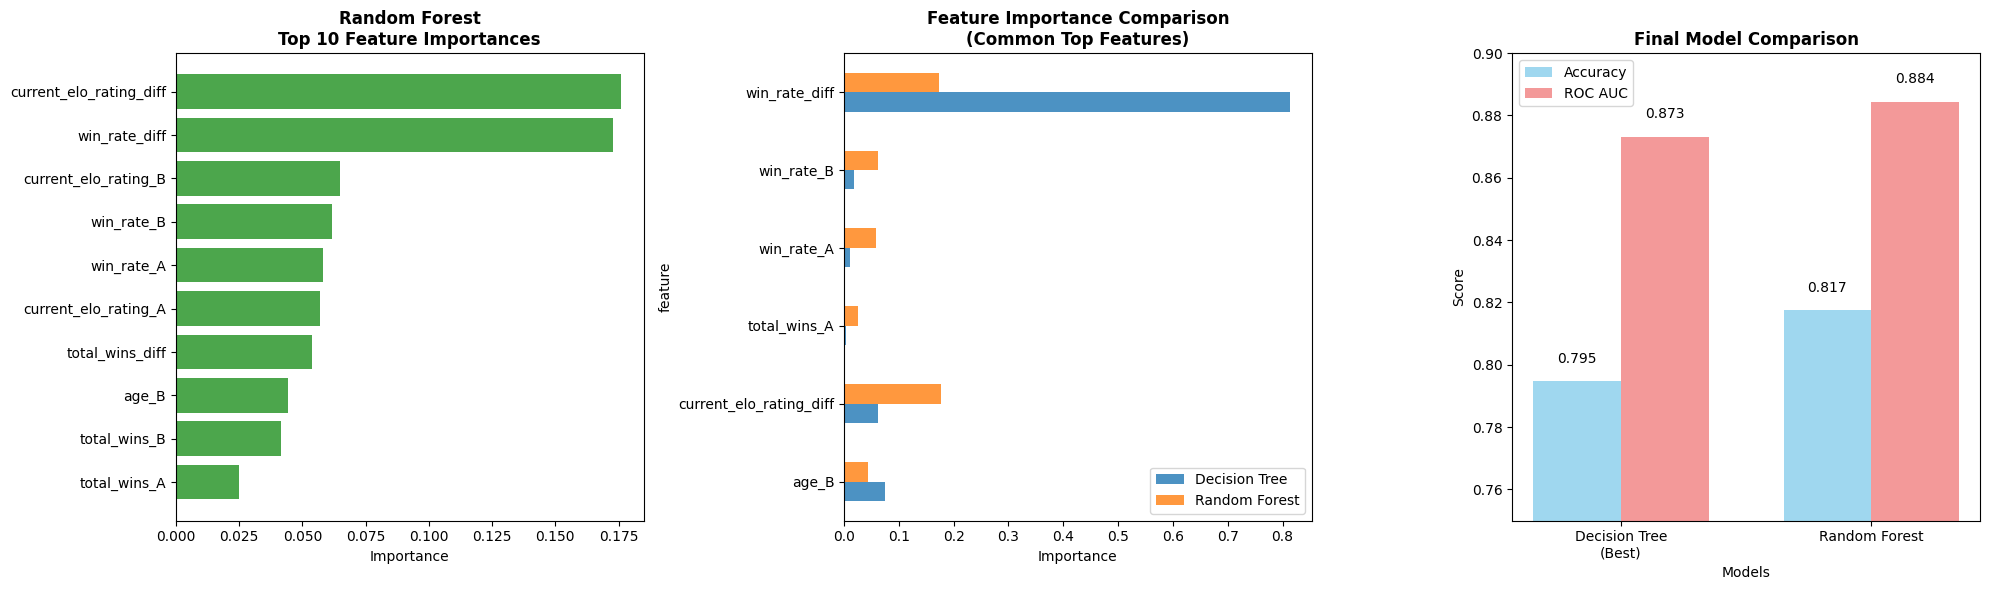


SUMMARY INSIGHTS
Best Performing Model: Random Forest

Top 3 Most Important Features (Best Decision Tree):
  37. win_rate_diff: 0.8127
  24. age_B: 0.0744
  32. current_elo_rating_diff: 0.0616

Top 3 Most Important Features (Random Forest):
  32. current_elo_rating_diff: 0.1761
  37. win_rate_diff: 0.1730
  18. current_elo_rating_B: 0.0648

Model Performance Summary:
  Decision Tree (Tuned): Accuracy=0.795, ROC AUC=0.873
  Random Forest:         Accuracy=0.817, ROC AUC=0.884

Detailed Classification Report - Best Model:
Random Forest:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       578
           1       0.84      0.88      0.86      1049

    accuracy                           0.82      1627
   macro avg       0.80      0.79      0.80      1627
weighted avg       0.82      0.82      0.82      1627



In [12]:
# 8. Random Forest Analysis and Comparison
print("\n" + "="*50)
print("RANDOM FOREST ANALYSIS")
print("="*50)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print(f"Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Feature importance comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[0].barh(range(len(rf_importance)), rf_importance['importance'], color='green', alpha=0.7)
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest\nTop 10 Feature Importances', fontweight='bold')
axes[0].invert_yaxis()

# 2. Decision Tree vs Random Forest Feature Importance
common_features = set(feature_importance.head(10)['feature']) & set(rf_importance.head(10)['feature'])
dt_common = feature_importance[feature_importance['feature'].isin(common_features)].set_index('feature')
rf_common = rf_importance[rf_importance['feature'].isin(common_features)].set_index('feature')

comparison_df = pd.DataFrame({
    'Decision Tree': dt_common['importance'],
    'Random Forest': rf_common['importance']
}).fillna(0)

comparison_df.plot(kind='barh', ax=axes[1], alpha=0.8)
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance Comparison\n(Common Top Features)', fontweight='bold')
axes[1].legend()

# 3. Model Performance Comparison
models = ['Decision Tree\n(Best)', 'Random Forest']
accuracies = [accuracy_score(y_test, y_pred_dt_best), accuracy_score(y_test, y_pred_rf)]
aucs = [roc_auc_score(y_test, y_proba_dt_best), roc_auc_score(y_test, y_proba_rf)]

x = np.arange(len(models))
width = 0.35

axes[2].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
axes[2].bar(x + width/2, aucs, width, label='ROC AUC', alpha=0.8, color='lightcoral')

axes[2].set_xlabel('Models')
axes[2].set_ylabel('Score')
axes[2].set_title('Final Model Comparison', fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].legend()
axes[2].set_ylim(0.75, 0.9)

# Add value labels
for i, (acc, auc) in enumerate(zip(accuracies, aucs)):
    axes[2].text(i - width/2, acc + 0.005, f'{acc:.3f}', ha='center', va='bottom')
    axes[2].text(i + width/2, auc + 0.005, f'{auc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*50)
print("SUMMARY INSIGHTS")
print("="*50)

print(f"Best Performing Model: {'Random Forest' if roc_auc_score(y_test, y_proba_rf) > roc_auc_score(y_test, y_proba_dt_best) else 'Decision Tree'}")
print(f"\nTop 3 Most Important Features (Best Decision Tree):")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\nTop 3 Most Important Features (Random Forest):")
for i, row in rf_importance.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\nModel Performance Summary:")
print(f"  Decision Tree (Tuned): Accuracy={accuracy_score(y_test, y_pred_dt_best):.3f}, ROC AUC={roc_auc_score(y_test, y_proba_dt_best):.3f}")
print(f"  Random Forest:         Accuracy={accuracy_score(y_test, y_pred_rf):.3f}, ROC AUC={roc_auc_score(y_test, y_proba_rf):.3f}")

# Classification reports
print(f"\nDetailed Classification Report - Best Model:")
if roc_auc_score(y_test, y_proba_rf) > roc_auc_score(y_test, y_proba_dt_best):
    print("Random Forest:")
    print(classification_report(y_test, y_pred_rf))
else:
    print("Decision Tree (Tuned):")
    print(classification_report(y_test, y_pred_dt_best))


In [13]:
# Check what model variables exist
print("Available variables in this notebook:")
for var_name in dir():
    if not var_name.startswith('_'):
        var_value = eval(var_name)
        if hasattr(var_value, 'predict'):  # Check if it's a model
            print(f"  {var_name}: {type(var_value).__name__}")

Available variables in this notebook:
  DecisionTreeClassifier: ABCMeta
  GridSearchCV: ABCMeta
  RandomForestClassifier: ABCMeta
  dt_best: DecisionTreeClassifier
  dt_grid: GridSearchCV
  dt_simple: DecisionTreeClassifier
  dt_viz: DecisionTreeClassifier
  rf: RandomForestClassifier


In [14]:
# Check if variables exist before saving
print("Checking if model variables exist...")

if 'dt_best' in locals():
    print("✓ dt_best exists:", type(dt_best))
else:
    print("❌ dt_best not found - need to train decision tree first")

if 'feature_cols' in locals():
    print("✓ feature_cols exists:", len(feature_cols), "features")
else:
    print("❌ feature_cols not found")

if 'rf' in locals():
    print("✓ rf exists:", type(rf))
else:
    print("⚠️  rf not found (random forest)")

# Show all available model variables
print("\nAll available variables that look like models:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'predict'):
                print(f"  {var_name}: {type(var_value).__name__}")
        except:
            pass

Checking if model variables exist...
✓ dt_best exists: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
✓ feature_cols exists: 41 features
✓ rf exists: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

All available variables that look like models:
  DecisionTreeClassifier: ABCMeta
  GridSearchCV: ABCMeta
  RandomForestClassifier: ABCMeta
  dt_best: DecisionTreeClassifier
  dt_grid: GridSearchCV
  dt_simple: DecisionTreeClassifier
  dt_viz: DecisionTreeClassifier
  rf: RandomForestClassifier


In [15]:
# Save the trained models
import pickle
import os

os.makedirs("../models", exist_ok=True)

# Save Decision Tree model
dt_model_data = {
    'model': dt_best,
    'features': feature_cols,
    'model_type': 'DecisionTree'
}

with open("../models/decision_tree_model.pkl", "wb") as f:
    pickle.dump(dt_model_data, f)

# Save Random Forest if available
if 'rf' in locals():
    rf_model_data = {
        'model': rf,
        'features': feature_cols,
        'model_type': 'RandomForest'
    }
    
    with open("../models/random_forest_model.pkl", "wb") as f:
        pickle.dump(rf_model_data, f)
    
    print("✓ Random Forest model saved!")

print("✓ Decision Tree model saved!")

✓ Random Forest model saved!
✓ Decision Tree model saved!
